In [2]:
import pandas as pd
import numpy as np
from arch import arch_model
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
base_time = datetime.strptime("00:00:00", "%H:%M:%S")
df = pd.read_parquet("combined1minutedata.parquet")
df["underlying_price"] = df["underlying_price"].astype(float)
df.loc[:, "time"] = df["ms_of_day"].apply(
    lambda ms_of_day: (base_time + timedelta(milliseconds=ms_of_day)).time()
)
df.set_index(["date", "time"], inplace=True)

In [27]:
ROLLING_WINDOW = 30

def garch_calc(rtn):
    am = arch_model(rtn.dropna().values*100)
    res = am.fit(disp="off")
    forecasts = res.forecast(horizon=5)
    # 390 minutes per day
    vol_forecast = (
        forecasts.residual_variance.iloc[-1, :].sum() * 390 / 5
    ) ** 0.5 / 100
    return vol_forecast

def sigma(price, method="garch"):
    if method == "hist":
        return (price.pct_change()*100).std() * (390**0.5)
    elif method == "garch":
        return garch_calc(price.pct_change()*100)
    elif method == "realized":
        return np.sqrt(((price.pct_change()*100)**2).sum()) * np.sqrt(
            390
        )


def find_strike(underlying_price, strike, callput="C", spread=0):
    sign = 1 if callput == "C" else -1
    if len(underlying_price) == 0:
        print("Invalid underlying_price")
        return np.nan
    if len(strike) == 0:
        print("Invalid strike")
        return np.nan

    price = underlying_price.iloc[0]
    while True:
        closest_index = np.argmin(np.abs((strike.values - price))) + sign * spread
        if abs(closest_index) < len(strike):
            closest_value = strike.iloc[closest_index]
            break
        else:
            # closest_value = strike.iloc[closest_index - sign * spread]
            spread = spread - 1

    return closest_value


def iv_on_spread(df):
    df_iv = pd.DataFrame()
    for spread in range(0, 5):
        atm_iv_col_name = f"atm_plus_{spread}spread_iv"
        atm_col_name = f"atm_plus_{spread}spread"
        df_day_call = df.loc[df["right"] == "C"].reset_index().set_index("time")
        df_day_call.loc[:, atm_col_name] = df_day_call.groupby(["time"]).apply(
            lambda rows: find_strike(
                rows["underlying_price"], rows["strike"], "C", spread=spread
            )
        )
        df_iv_call = df_day_call.loc[
            df_day_call["strike"] == df_day_call[atm_col_name]
        ]["implied_vol"].to_frame()
        df_iv_call.columns = [atm_iv_col_name + "_CALL"]

        df_day_put = df.loc[df["right"] == "P"].reset_index().set_index("time")
        df_day_put.loc[:, atm_col_name] = df_day_put.groupby(["time"]).apply(
            lambda rows: find_strike(
                rows["underlying_price"], rows["strike"], "P", spread=spread
            )
        )
        df_iv_put = df_day_put.loc[df_day_put["strike"] == df_day_put[atm_col_name]][
            "implied_vol"
        ].to_frame()
        df_iv_put.columns = [atm_iv_col_name + "_PUT"]

        df_iv = pd.concat(
            [
                df_iv,
                df_iv_call,
                df_iv_put,
            ],
            axis=1,
        )

    return df_iv


def pnl_on_spread(df):
    df_pnl = pd.DataFrame()
    for spread in range(0, 5):
        atm_col_name = f"atm_plus_{spread}spread"
        atm_pnl_col_name = f"atm_plus_{spread}spread_pnl"
        df_day_call = df.loc[df["right"] == "C"].reset_index().set_index("time")

        df_day_call.loc[:, atm_col_name] = df_day_call.groupby(["time"]).apply(
            lambda rows: find_strike(
                rows["underlying_price"], rows["strike"], "C", spread=spread
            )
        )

        df_pnl_call = df_day_call.loc[
            df_day_call["strike"] == df_day_call[atm_col_name]
        ]["EOD_PnL"].to_frame()

        df_day_put = df.loc[df["right"] == "P"].reset_index().set_index("time")
        df_day_put.loc[:, atm_col_name] = df_day_put.groupby(["time"]).apply(
            lambda rows: find_strike(
                rows["underlying_price"], rows["strike"], "P", spread=spread
            )
        )

        df_pnl_put = df_day_put.loc[df_day_put["strike"] == df_day_put[atm_col_name]][
            "EOD_PnL"
        ].to_frame()

        df_pnl_sum_spread = df_pnl_call + df_pnl_put
        df_pnl_sum_spread.columns = [atm_pnl_col_name]

        df_pnl = pd.concat(
            [df_pnl, df_pnl_sum_spread],
            axis=1,
        )
    return df_pnl


def plot_volatility(df, df_iv, df_pnl, DAY):
    # Convert index to datetime
    df.index = pd.to_datetime(df.index, format="%H:%M:%S", errors="coerce")
    df_iv.index = pd.to_datetime(df_iv.index, format="%H:%M:%S", errors="coerce")
    df_pnl.index = pd.to_datetime(df_pnl.index, format="%H:%M:%S", errors="coerce")

    # Create a figure with 3 subplots (3 rows, 1 column)
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

    # Plot 1: Volatility and Price (Primary Plot)
    ax1.plot(df.index, df["Garch_Vlty"], color="blue", label="Garch Volatility")
    ax1.plot(df.index, df["Hist_Vlty"], color="green", label="Historical Volatility")
    ax1.set_ylabel("Volatility", color="blue")
    ax1.tick_params(axis="y", colors="blue")

    # Secondary y-axis for Price
    ax1_secondary = ax1.twinx()
    ax1_secondary.plot(df.index, df["Price"], color="red", label="Price")
    ax1_secondary.set_ylabel("Price", color="red")
    ax1_secondary.tick_params(axis="y", colors="red")

    # Add legends for the first subplot
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1_secondary.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

    # Plot 2: Implied Volatility (df_iv)
    # Use unique colors and labels for each line in df_iv
    for col in df_iv.columns:
        ax2.plot(df_iv.index, df_iv[col], label=f"{col}")
    ax2.set_ylabel("Implied Volatility", color="purple")
    ax2.tick_params(axis="y", colors="purple")
    ax2.legend(loc="upper left")

    # Plot 3: PnL (df_pnl)
    # Use unique colors and labels for each line in df_pnl
    for col in df_pnl.columns:
        ax3.plot(df_pnl.index, df_pnl[col], label=f"{col}")
    ax3.set_ylabel("PnL", color="orange")
    ax3.tick_params(axis="y", colors="orange")
    ax3.legend(loc="upper left")

    # Customize x-axis for all subplots
    for ax in [ax1, ax2, ax3]:
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Ticks every hour
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))  # Format as HH:MM
        ax.grid(True, which="both", axis="x", linestyle="--", linewidth=0.5)

    # Set common x-axis label
    ax3.set_xlabel("Time")

    # Add a title for the entire figure
    fig.suptitle(
        f"Volatility, Price, Implied Volatility, and PnL Over Time on {DAY}",
        fontsize=14,
    )

    # Improve layout
    plt.tight_layout()
    plt.show()

In [28]:
def chart_by_day(DAY):
    df_day_price = df.groupby(["date", "time"])["underlying_price"].first()
    df_vlty = (
        df_day_price.loc[df_day_price.index.get_level_values(0) == DAY]
        .rolling(ROLLING_WINDOW)
        .apply(lambda x: sigma(x, method="garch"))
        .reset_index()
        .set_index("time")
    )
    df_histvlty = (
        df_day_price.loc[df_day_price.index.get_level_values(0) == DAY]
        .rolling(ROLLING_WINDOW)
        .apply(lambda x: sigma(x, method="hist"))
        .reset_index()
        .set_index("time")
    )

    df_price = (
        df_day_price.loc[df_day_price.index.get_level_values(0) == DAY]
        .reset_index()
        .set_index("time")
    )

    df_iv = iv_on_spread(df.loc[(df.index.get_level_values(0) == DAY)])
    df_pnl = pnl_on_spread(df.loc[(df.index.get_level_values(0) == DAY)])


    df_vlty = pd.concat(
        [
            df_vlty["underlying_price"],
            df_histvlty["underlying_price"],
            df_price["underlying_price"],
        ],
        axis=1,
    )
    df_vlty.columns = ["Garch_Vlty", "Hist_Vlty", "Price"]
    df_vlty = df_vlty.fillna(0)
    plot_volatility(df_vlty, df_iv, df_pnl, DAY=DAY)

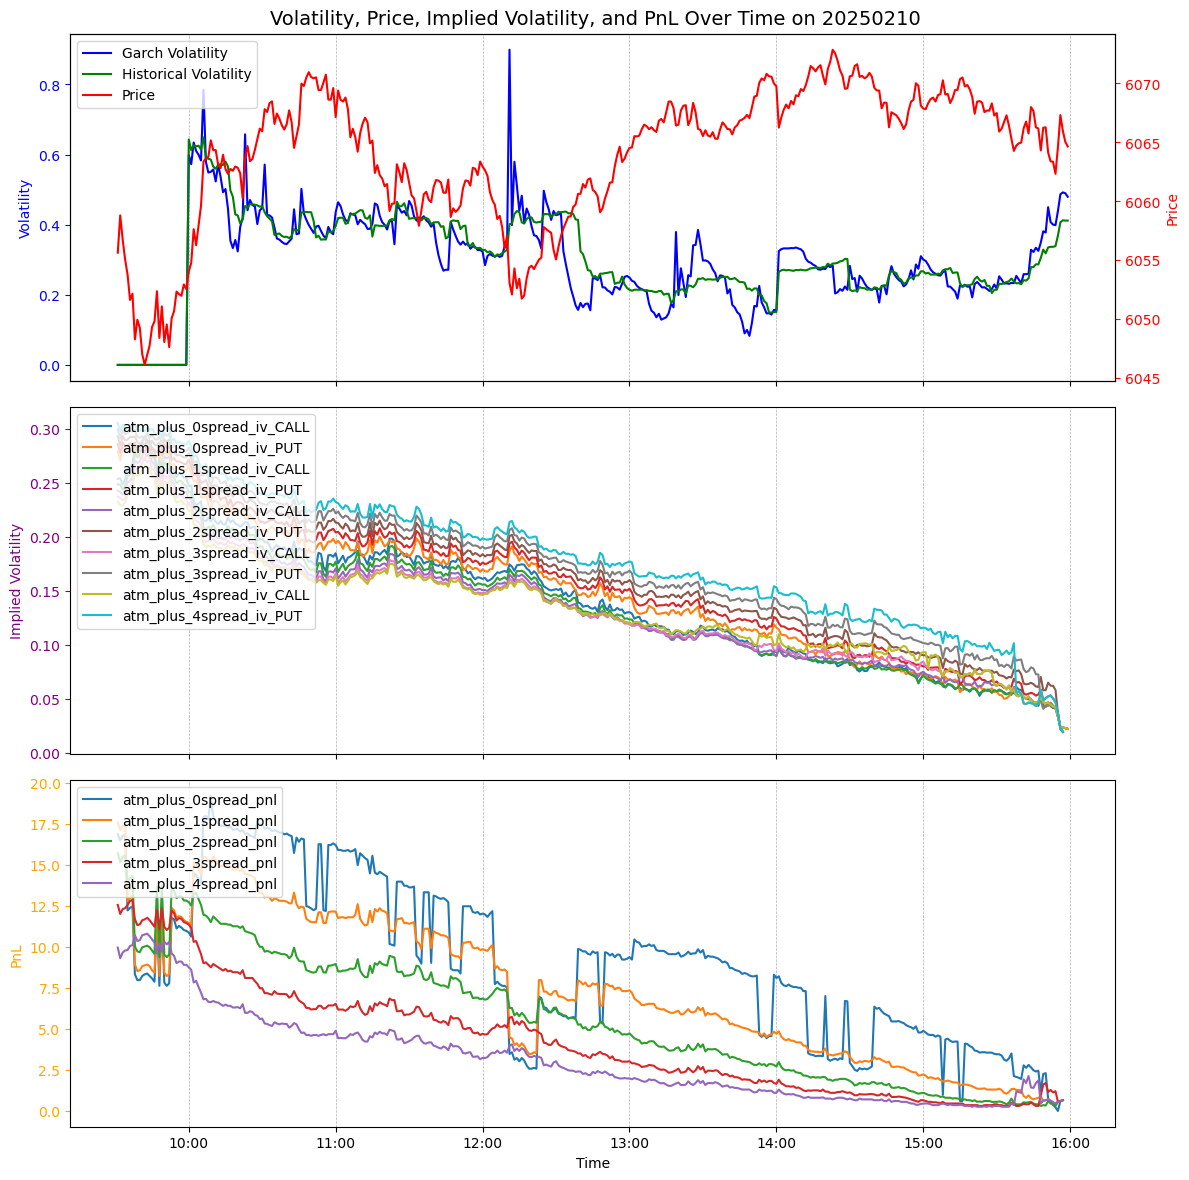

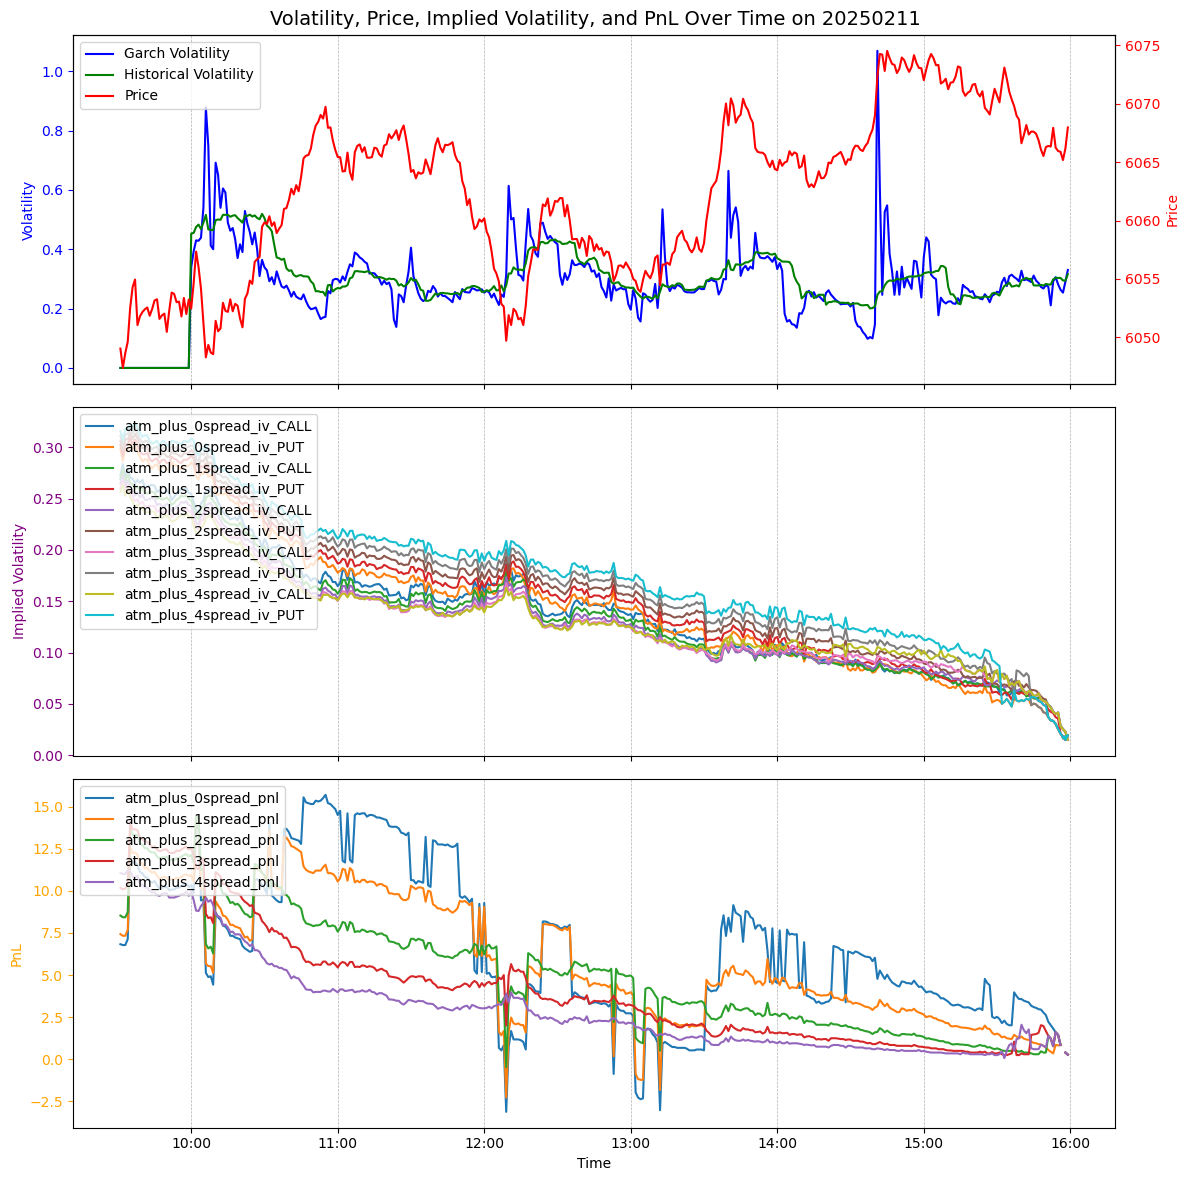

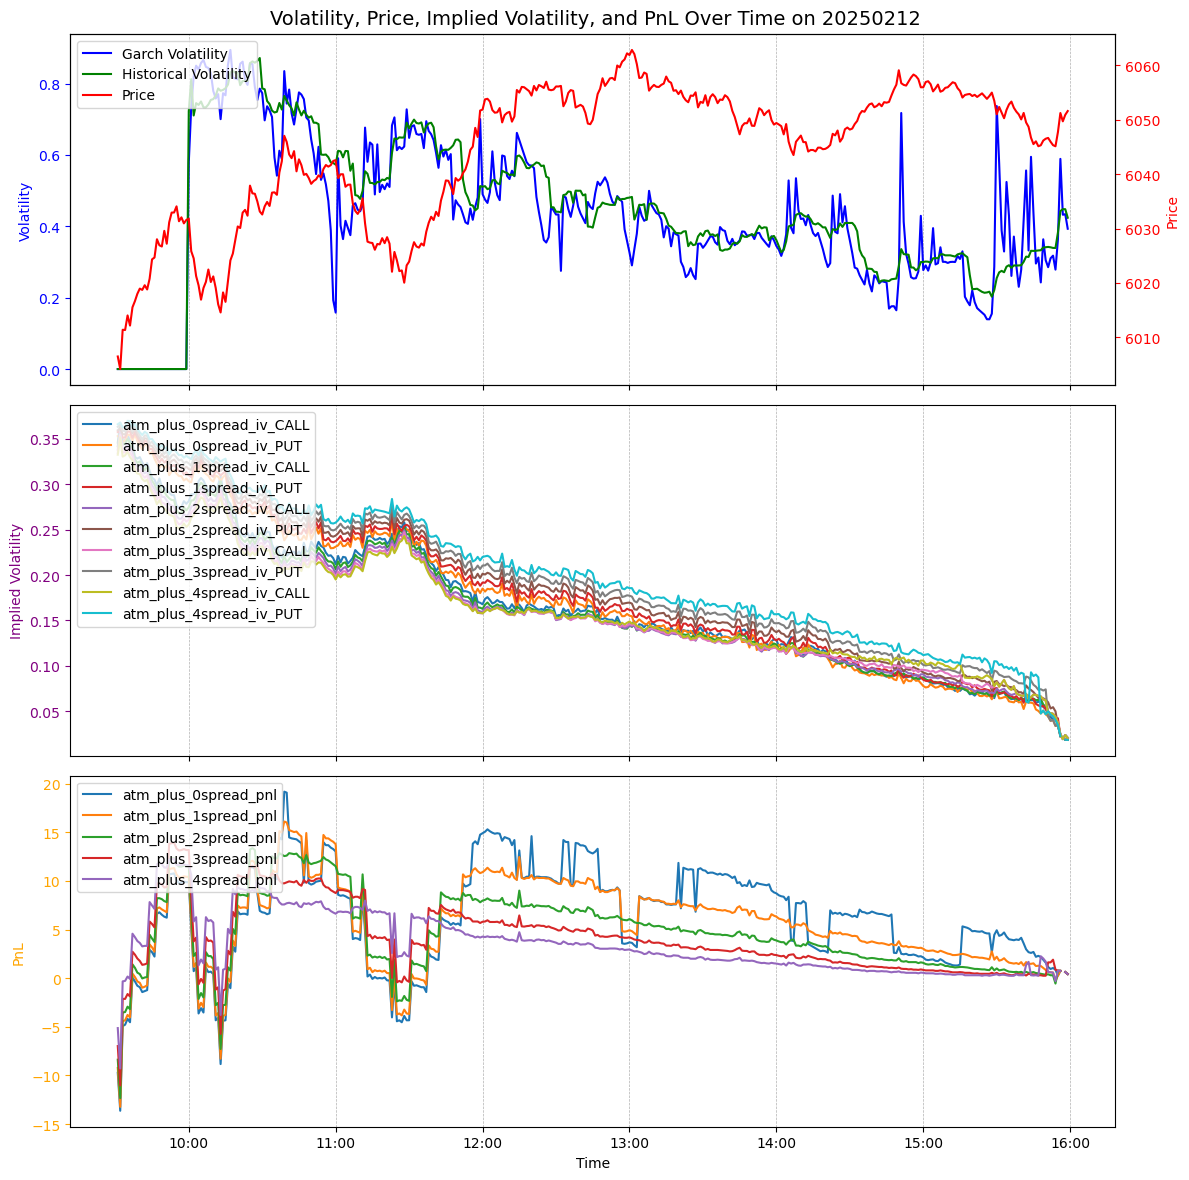

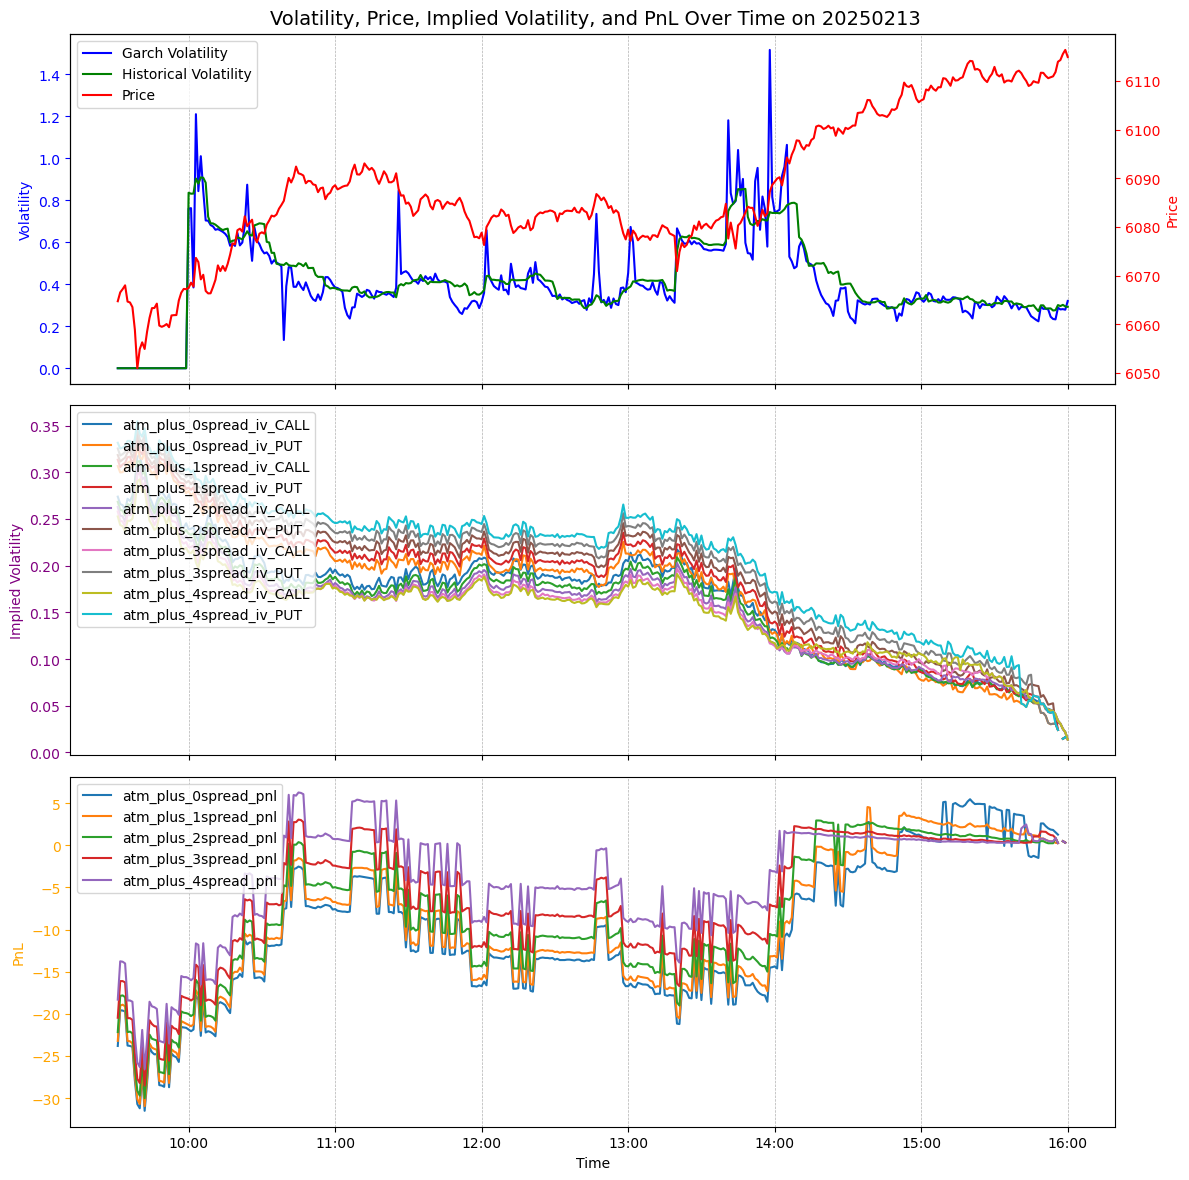

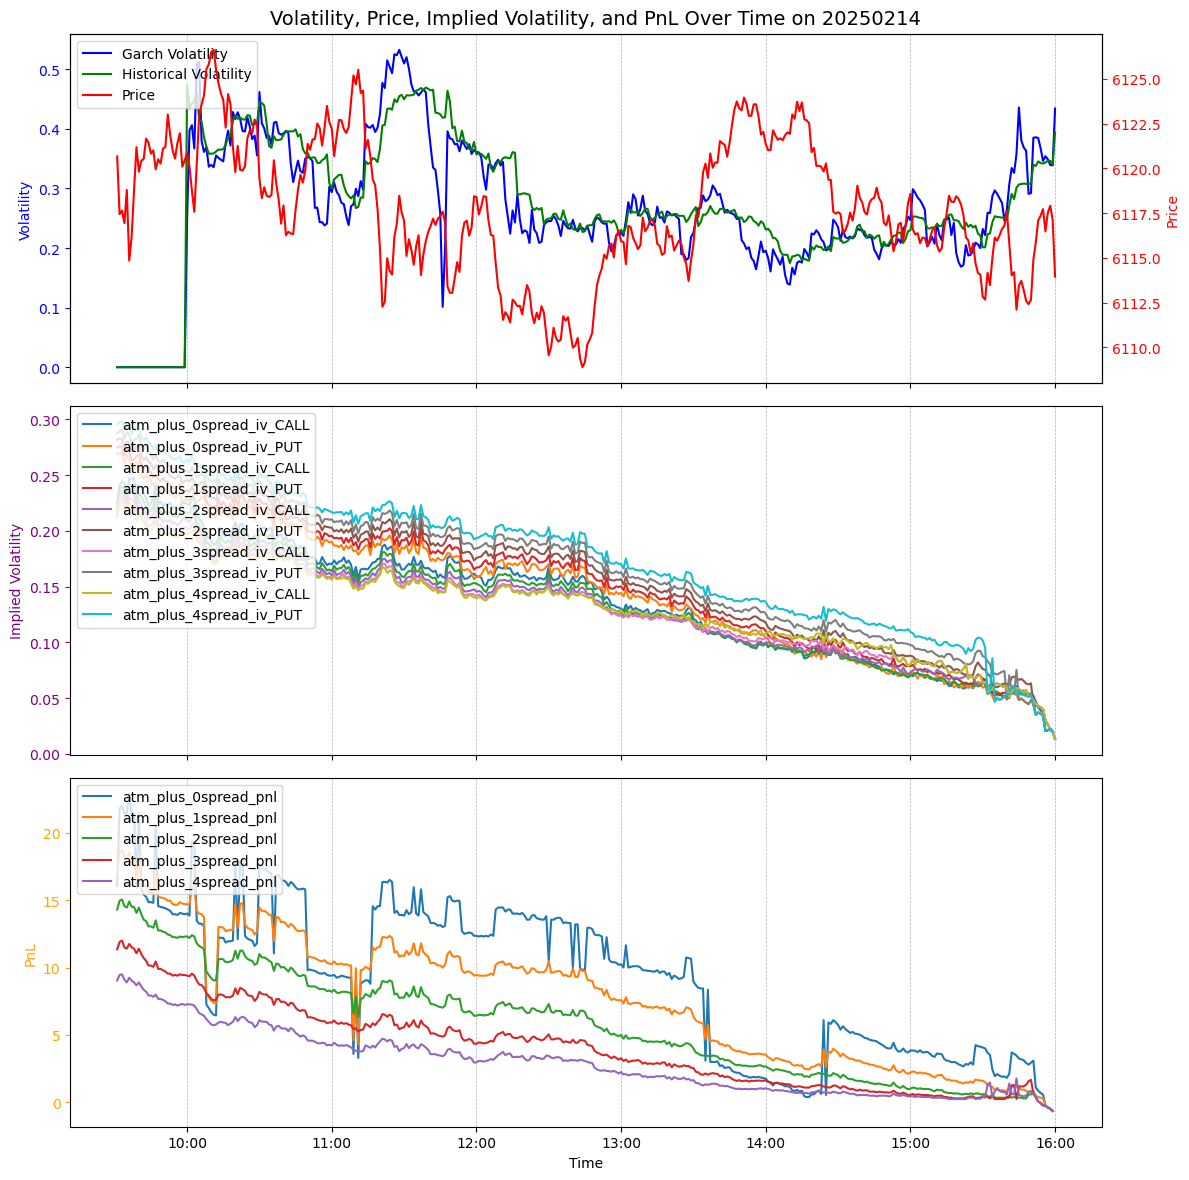

In [30]:
#chart_by_day("20250206")
#chart_by_day("20250207")
chart_by_day("20250210")
chart_by_day("20250211")
chart_by_day("20250212")
chart_by_day("20250213")
chart_by_day("20250214")

In [ ]:
df_day.loc[:, "extrinsic"] = (
    np.maximum(0, df_day["underlying_price"] - df_day["strike"]) + df_day["mid"]
)
df_day

C:\Users\hui\AppData\Local\Temp\ipykernel_33576\1724426471.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_day.loc[:, "extrinsic"] = (


,date,ms_of_day,strike,right,underlying_price,bid,ask,mid,delta,implied_vol,OTMAmount,EOD_PnL,extrinsic
12289260,09:31:00,34260000,6065.0,C,6064.72,13.2,13.50,13.350,0.4990,0.2739,0.28,-36.570,13.350
12289261,09:31:00,34260000,6070.0,C,6064.72,10.6,10.90,10.750,0.4388,0.2684,5.28,-34.170,10.750
12289262,09:31:00,34260000,6075.0,C,6064.72,8.4,8.50,8.450,0.3775,0.2628,10.28,-31.470,8.450
12289263,09:31:00,34260000,6080.0,C,6064.72,6.4,6.60,6.500,0.3173,0.2579,15.28,-28.420,6.500
12289264,09:31:00,34260000,6085.0,C,6064.72,4.8,4.90,4.850,0.2592,0.2527,20.28,-25.070,4.850
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12302868,15:56:00,57360000,6120.0,C,6113.95,0.1,0.20,0.150,0.0790,0.0339,6.05,0.150,0.150
12302869,15:57:00,57420000,6115.0,C,6114.30,1.2,1.30,1.250,0.4386,0.0308,0.70,1.250,1.250
12302871,15:58:00,57480000,6120.0,C,6115.53,0.1,0.15,0.125,0.0830,0.0253,4.47,0.125,0.125
12302873,15:59:00,57540000,6120.0,C,6116.38,0.1,0.15,0.125,0.0950,0.0216,3.62,0.125,0.125


: 